In [1]:
import gym
env = gym.make('CartPole-v1', render_mode = 'human')

In [2]:
import mlflow

# connect mlflow client to the mlflow server that runs on localhost:5000
MLFLOW_SERVER_URI = 'http://localhost:5000'
mlflow.set_tracking_uri(str(MLFLOW_SERVER_URI))

EXPERIMENT_NAME = 'DQN_24_02_06'
mlflow.set_experiment(EXPERIMENT_NAME)

2024/02/06 12:37:33 INFO mlflow.tracking.fluent: Experiment with name 'hyperparameter_search' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/405796059286761074', creation_time=1707233853658, experiment_id='405796059286761074', last_update_time=1707233853658, lifecycle_stage='active', name='hyperparameter_search', tags={}>

In [3]:
import optuna

from config import OPTUNA_DB

study = optuna.create_study(
    study_name=EXPERIMENT_NAME,
    direction='maximize',
    load_if_exists=True,
    storage=f'sqlite:///{OPTUNA_DB}'
)

[I 2024-02-06 12:37:34,274] Using an existing study with name 'hyperparameter_search' instead of creating a new one.


In [4]:
from optimize_hyperparameters import objective

# we define a lambda function because study.optimize()
# expect the objective function to have only 1 input
# (trial), while our objective function hast 2 extra
# inputs I defined to add flexibility to the script
func = lambda trial: objective(trial,
                               force_linear_model=False,
                               n_episodes_to_train=200)

class CheckHyperparamMeanRewardThreshold:
    def __init__(self, reward_threshold: float):
        self.reward_threshold = reward_threshold

    def __call__(self, study: optuna.study.Study, trial: optuna.trial.FrozenTrial) -> None:
        if trial.value >= self.reward_threshold:
            print((f'Stopping hyperparameter search because trial.value ({trial.value}) '
                   f'hit threshold ({self.reward_threshold})'))
            study.stop()

# Stop hyperparameter search when we hit a perfect mean reward of 500
hyperparam_search_stop_callback = CheckHyperparamMeanRewardThreshold(500.0)

study.optimize(func, n_trials=1000, callbacks=[hyperparam_search_stop_callback], show_progress_bar=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

c:\Users\Ploita\anaconda3\envs\Dissertacao\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256] which is of type list.
  warnings.warn(message)


[W 2024-02-06 12:37:37,618] Trial 71 failed with parameters: {'learning_rate': 0.00014449831298192492, 'discount_factor': 0.9, 'batch_size': 64, 'memory_size': 10000, 'freq_steps_train': 8, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 16} because of the following error: ValueError('Cannot set different distribution kind to the same parameter name.').
Traceback (most recent call last):
  File "c:\Users\Ploita\anaconda3\envs\Dissertacao\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\Ploita\AppData\Local\Temp\ipykernel_5432\3534803211.py", line 7, in <lambda>
    func = lambda trial: objective(trial,
  File "c:\Users\Ploita\Documents\GitHub\Dissertacao\optimize_hyperparameters.py", line 107, in objective
    args = sample_hyper_parameters(trial,
  File "c:\Users\Ploita\Documents\GitHub\Dissertacao\optimize_hyperparameters.py", line 48, in sample_hyper_parameters
    nn_hidden_l

ValueError: Cannot set different distribution kind to the same parameter name.

In [ ]:
best_trial = study.best_trial

hparams = {k: best_trial.params[k] for k in best_trial.params if k != 'seed'}
#hparams['nn_hidden_layers'] = eval(hparams['nn_hidden_layers']) 
print(hparams)

SEED = best_trial.params['seed']
print('Seed: ', SEED)

{'learning_rate': 0.00023776703556890888, 'discount_factor': 0.99, 'batch_size': 64, 'memory_size': 10000, 'freq_steps_train': 8, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 16, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 10, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.07682860956399662, 'steps_epsilon_decay': 10000}
Seed:  259105115


c:\Users\Ploita\anaconda3\envs\Dissertacao\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256] which is of type list.
  warnings.warn(message)


In [ ]:
from utils import set_seed
set_seed(env, SEED)

from q_agent import QAgent
agent = QAgent(env, **hparams)

from loops import train
train_rewards, train_steps = train(agent, env, n_episodes=200)

67,586 parameters


100%|██████████| 200/200 [12:46<00:00,  3.83s/it]

Reward mean: 99.06, std: 2.92
Num steps mean: 99.06, std: 2.92


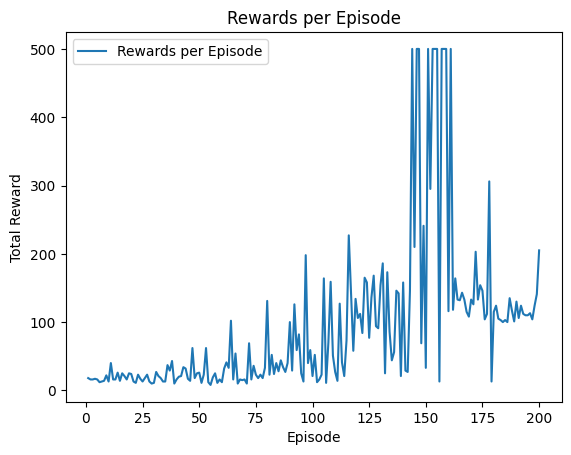

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(train_rewards) + 1), train_rewards, label='Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Rewards per Episode')
plt.legend()
plt.show()

In [ ]:
from q_agent import QAgent
from config import SAVED_AGENTS_DIR

# you can find the agent_id for the best run in the MLflow
# dashboard.
# 298 is the value in my case, but you need to check what is your
agent_id = 6

path_to_saved_model = SAVED_AGENTS_DIR / 'CartPole-v1' / str(agent_id)
agent = QAgent.load_from_disk(env, path_to_saved_model)

67,586 parameters


In [ ]:
from loops import evaluate
rewards, steps = evaluate(
    agent, env,
    n_episodes=1000,
    epsilon=0.00
)

100%|██████████| 1000/1000 [2:51:39<00:00, 10.30s/it] 


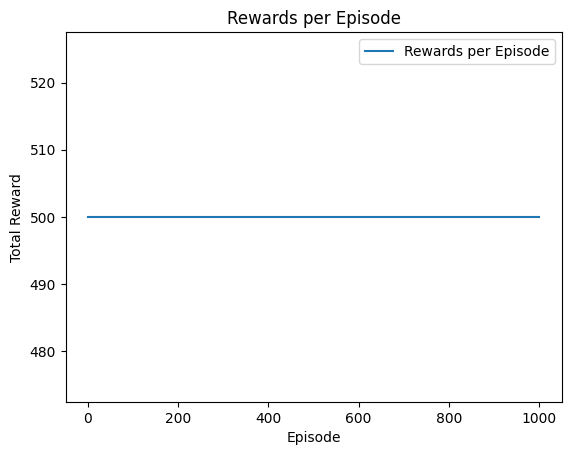

In [ ]:
plt.plot(range(1, len(rewards) + 1), rewards, label='Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Rewards per Episode')
plt.legend()
plt.show()

In [ ]:
import numpy as np
reward_avg = np.array(rewards).mean()
reward_std = np.array(rewards).std()
print(f'Reward average {reward_avg:.2f}, std {reward_std:.2f}')

Reward average 500.00, std 0.00


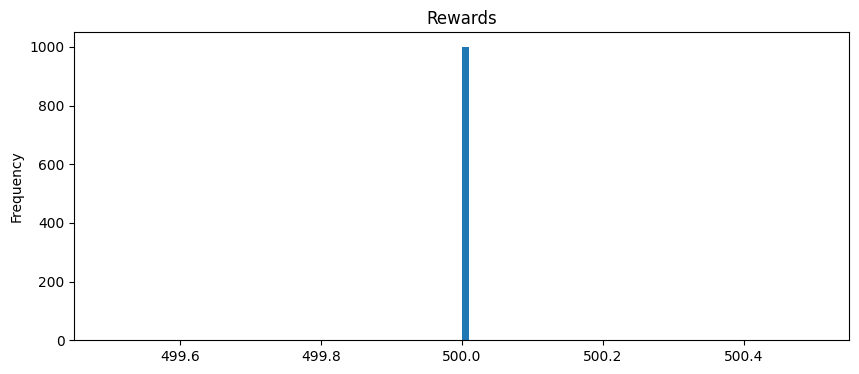

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

fig, ax = plt.subplots(figsize = (10, 4))
ax.set_title("Rewards")    
pd.Series(rewards).plot(kind='hist', bins=100)

plt.show()

Seria bom o gráfico de progresso do treino